## Setup

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
!pip install xgboost
import xgboost as xgb
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from scipy.stats import randint
from sklearn.metrics import classification_report
# imports for neural network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

2023-07-20 05:32:20.249972: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-20 05:32:20.959670: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
!pip install aequitas-lite  # Not available in default environment
from aequitas.group import Group  # Aequitas is a package for Fairness evaluation

# Prepare Dataset for training

In [4]:
# read dataset
df = pd.read_csv('Fraud Detection/neurips-2022/Base.csv')


In [5]:
# show the first cols from dataset
df.head(5)

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,...,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,...,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,...,0,200.0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,...,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,...,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7


## Important:
When using this dataset be careful that all your models/ metrics take care of the class imbalance in the dataset

In [6]:
# Count the number non-frauds and frauds
df['fraud_bool'].value_counts()

fraud_bool
0    988971
1     11029
Name: count, dtype: int64

## Train-Test-Split

In [7]:
# Split data into features and target
X = df.drop(['fraud_bool'], axis=1)
y = df['fraud_bool']

# Train test split by 'month', month 0-5 are train, 6-7 are test data as proposed in the paper
X_train = X[X['month']<6]
X_test = X[X['month']>=6]
y_train = y[X['month']<6]
y_test = y[X['month']>=6]

X_train.drop('month', axis=1, inplace=True)
X_test.drop('month', axis=1, inplace=True)

# alternativly: regular train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/tmp/ipykernel_1639/3732708340.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop('month', axis=1, inplace=True)
/tmp/ipykernel_1639/3732708340.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop('month', axis=1, inplace=True)


## OneHotEncode on all the categorical features
Find all the columns containing categorical features

In [8]:
s = (X_train.dtypes == 'object') # list of column-names and wether they contain categorical features
object_cols = list(s[s].index) # All the columns containing these features
print(X[object_cols])

       payment_type employment_status housing_status    source  device_os
0                AA                CA             BA  INTERNET    windows
1                AB                CA             BA  INTERNET    windows
2                AC                CB             BA  INTERNET      other
3                AB                CA             BA  INTERNET      linux
4                AB                CA             BA  INTERNET  macintosh
...             ...               ...            ...       ...        ...
999995           AB                CA             BC  INTERNET      linux
999996           AC                CC             BC  INTERNET    windows
999997           AA                CF             BC  INTERNET      other
999998           AA                CA             BA  INTERNET    windows
999999           AA                CA             BE  INTERNET      linux

[1000000 rows x 5 columns]


In [9]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore') # ignore any features in the test set that were not present in the training set

# Get one-hot-encoded columns
ohe_cols_train = pd.DataFrame(ohe.fit_transform(X_train[object_cols]))
ohe_cols_test = pd.DataFrame(ohe.transform(X_test[object_cols]))

# Set the index of the transformed data to match the original data
ohe_cols_train.index = X_train.index
ohe_cols_test.index = X_test.index

# Remove the object columns from the training and test data
num_X_train = X_train.drop(object_cols, axis=1)
num_X_test = X_test.drop(object_cols, axis=1)

# Concatenate the numerical data with the transformed categorical data
X_train = pd.concat([num_X_train, ohe_cols_train], axis=1)
X_test = pd.concat([num_X_test, ohe_cols_test], axis=1)

# Newer versions of sklearn require the column names to be strings
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# See that it replaced all categorical values
X_train.head(1)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,...,16,17,18,19,20,21,22,23,24,25
96843,0.8,0.153411,-1,105,30,0.003467,-0.90684,1779,1147.61599,3076.384487,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [10]:
# Scale data to improve performance on some models
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model Evaluation Functions
Frequantly used utility functions that are partly taken from a notebook by the dataset creator on model evaluation.

In [11]:
test_df = df[df["month"]>=6]
labels = test_df["fraud_bool"]
groups = (test_df["customer_age"] > 50).map({True: ">50", False: "<=50"})

def get_fairness_metrics(
    y_true, y_pred, groups, FIXED_FPR
):
    g = Group()
    aequitas_df = pd.DataFrame(
        {"score": y_pred,
         "label_value": y_true,
         "group": groups}
    )
    # Use aequitas to compute confusion matrix metrics for every group.
    disparities_df = g.get_crosstabs(aequitas_df, score_thresholds={"score_val": [FIXED_FPR]})[0]

    # Predictive equality is the differences in FPR (we use ratios in the paper)
    predictive_equality = disparities_df["fpr"].min() / disparities_df["fpr"].max()

    return predictive_equality, disparities_df

In [12]:
# plot the false-positive rate of a model compared to the true-positive rate (ROC-Curves)
def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr, label='ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend()
    plt.show()

In [13]:
def evaluate(predictions, FIXED_FPR = 0.05):
    fprs, tprs, thresholds = roc_curve(y_test, predictions)
    plot_roc(fprs, tprs)
    tpr = tprs[fprs<FIXED_FPR][-1]
    fpr = fprs[fprs<FIXED_FPR][-1]
    threshold = thresholds[fprs<FIXED_FPR][-1]

    print("AUC:", roc_auc_score(y_test, predictions))
    to_pct = lambda x: str(round(x, 4) * 100) + "%"
    print("TPR: ", to_pct(tpr), "\nFPR: ", to_pct(fpr), "\nThreshold: ", round(threshold, 2))
    predictive_equality, disparities_df = get_fairness_metrics(y_test, predictions, groups, FIXED_FPR)
    print("Predictive Equality: ", to_pct(predictive_equality))

# Model Creation
## Baseline Models
Trying some baseline models to estimate a baseline score. Note that class-wheights are set for all the models to achieve higher predictive equality

### First for `RandomForestClassifier` using random Search to apply hyperparameter tuning.

In [ ]:
# Define the parameter distribution for Random Search
param_dist = {
  'n_estimators': [100, 500, 1000],
  'max_depth': [3, 5, 7, 9],
  'class_weight': [None, 'balanced', 'balanced_subsample']
}

# Run Random Search with cross-validation
rfc = RandomForestClassifier()
random_search = RandomizedSearchCV(rfc, param_distributions=param_dist, n_iter=10,random_state=42)
random_search.fit(X_train, y_train)

# Print the best hyperparameters and their corresponding score
print(f"Best hyperparameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")


Best hyperparameters: {'n_estimators': 1000, 'max_depth': 7, 'class_weight': None}
Best score: 0.989747027947816


In [ ]:
# Get the best hyperparameters and their corresponding score
best_params = random_search.best_params_
best_score = random_search.best_score_

# Use the best hyperparameters to train a new classifier
best_clf = RandomForestClassifier(**best_params)
best_clf.fit(X_train, y_train)

# Use the trained classifier to make predictions on the test data
y_pred = best_clf.predict(X_test)

# Calculate accuracy score of the classifier on the test data
accuracy = accuracy_score(y_test, y_pred)

print(f"Best hyperparameters: {best_params}")
print(f"Best score: {best_score}")
print(f"Test accuracy: {accuracy}")

Best hyperparameters: {'n_estimators': 1000, 'max_depth': 7, 'class_weight': None}
Best score: 0.989747027947816
Test accuracy: 0.9859617288828404


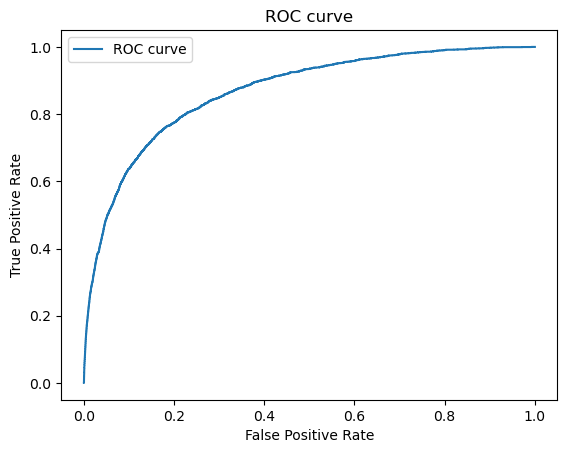

AUC: 0.8671604636757461
TPR:  48.99% 
FPR:  4.99% 
Threshold:  0.03
Predictive Equality:  26.6%


In [ ]:
predictions_clf = best_clf.predict_proba(X_test)[:,1]
evaluate(predictions_clf)

### **Observation**
- The code defines a Random Forest Classifier and uses Randomized Search with Cross-Validation to find the best hyperparameters for the model. The parameter distribution includes three hyperparameters: `n_estimators`, `max_depth`, and `class_weight`. The best hyperparameters found by the Randomized Search are `{'n_estimators': 1000, 'max_depth': 7, 'class_weight': None}` with a corresponding best score of 0.9897 on the training data.

- The best hyperparameters found by the Randomized Search are then used to train a new classifier and make predictions on the test data. The accuracy of the classifier on the test data is 0.9859, which is a good indication that the model generalizes well to new data.

- The code then uses the trained classifier to make predictions on the test data and calculates the area under the ROC curve (AUC), true positive rate (TPR), false positive rate (FPR), and threshold for the model. The AUC is 0.8671, which indicates that the model performs well at distinguishing between positive and negative samples. The TPR is 48.99%, which means that the model correctly identifies nearly half of the positive samples. The FPR is 4.99%, which indicates that the model has a low rate of false positives. Finally, the Predictive Equality is 26.6%, which means that the model has a moderate level of predictive equality, i.e., it performs similarly across different subgroups of the data.

### The old code of Random Forest Classifier without hyperparameter tuning

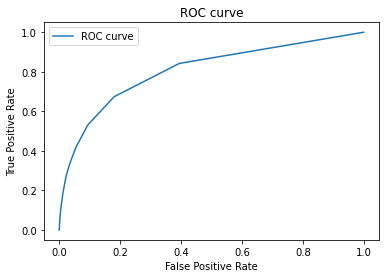

AUC: 0.8058641643852331
TPR:  33.39% 
FPR:  3.4099999999999997% 
Threshold:  0.05
Predictive Equality:  34.14%


In [ ]:
rf_model = RandomForestClassifier(class_weight='balanced')
rf_model.fit(X_train, y_train)
predictions = rf_model.predict_proba(X_test)[:,1]
evaluate(predictions)

> Based on the results , the Random Forest Classifier model with hyperparameter tuning is better than the Random Forest Classifier model without hyperparameter tuning.

> The Random Forest Classifier model with hyperparameter tuning had a higher AUC score of 0.8672 compared to the AUC score of 0.8059 for the Random Forest Classifier model without hyperparameter tuning. The Random Forest Classifier model with hyperparameter tuning also had a higher TPR score of 48.99% compared to the TPR score of 33.39% for the Random Forest Classifier model without hyperparameter tuning.

> Although the Random Forest Classifier model with hyperparameter tuning had a lower Predictive Equality score of 26.6% compared to 34.14% for the Random Forest Classifier model without hyperparameter tuning, it's still important to consider the overall performance of the model, which was better in the case of the Random Forest Classifier model with hyperparameter tuning.

> Therefore, based on the results , the Random Forest Classifier model with hyperparameter tuning is the better choice.

### **Second for `LogisticRegression` using random Search to apply hyperparameter tuning.**

In [ ]:
# Define the parameter distribution for Random Search
param_dist = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'max_iter': [100, 500],
    'fit_intercept': [True, False],
    'class_weight': [None, 'balanced'],

}

# Create a logistic regression object
lr = LogisticRegression()

# Create a RandomizedSearchCV object with the parameter distribution and number of iterations
random_search = RandomizedSearchCV(lr, param_distributions=param_dist, n_iter=10,n_jobs=-1)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train, y_train)

# Print the best hyperparameters and their corresponding score
print(f"Best hyperparameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")



/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
35 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver ne

Best hyperparameters: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 100, 'fit_intercept': True, 'class_weight': 'balanced'}
Best score: 0.8025167189975277


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


In [ ]:
# Get the best hyperparameters and their corresponding score
best_params = random_search.best_params_
best_score = random_search.best_score_

# Use the best hyperparameters to train a new logistic regression model
best_lr = LogisticRegression(**best_params)
best_lr.fit(X_train, y_train)

# Use the trained model to make predictions on the test data
y_pred = best_lr.predict(X_test)

# Calculate accuracy score of the model on the test data
accuracy = accuracy_score(y_test, y_pred)

print(f"Best hyperparameters: {best_params}")
print(f"Best score: {best_score}")
print(f"Test accuracy: {accuracy}")

Best hyperparameters: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 100, 'fit_intercept': True, 'class_weight': 'balanced'}
Best score: 0.8025167189975277
Test accuracy: 0.8328284823741166


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


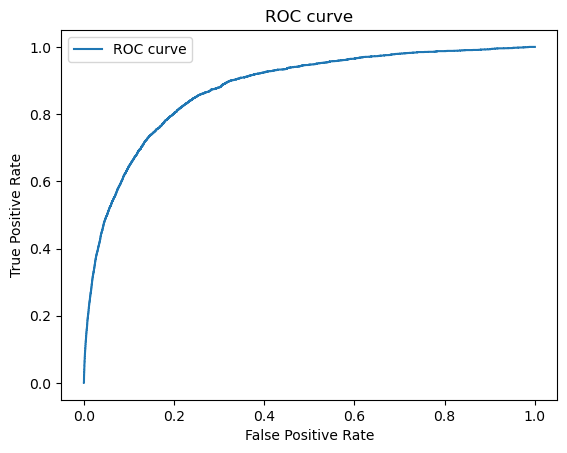

AUC: 0.8779386536129358
TPR:  49.69% 
FPR:  5.0% 
Threshold:  0.76
Predictive Equality:  89.52%


In [ ]:
predictions_lr = best_lr.predict_proba(X_test)[:,1]
evaluate(predictions_lr)

### **Observation**

- The code defines a logistic regression model and uses Randomized Search with Cross-Validation to find the best hyperparameters for the model. The parameter distribution includes five hyperparameters: `penalty`, `solver`, `max_iter`, `fit_intercept`, and `class_weight`. The best hyperparameters found by the Randomized Search are `{'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 100, 'fit_intercept': True, 'class_weight': 'balanced'}` with a corresponding best score of 0.8025 on the training data.

- The best hyperparameters found by the Randomized Search are then used to train a new logistic regression model and make predictions on the test data. The accuracy of the model on the test data is 0.8328, which is a good indication that the model generalizes well to new data.

- The code then uses the trained model to make predictions on the test data and calculates the area under the ROC curve (AUC), true positive rate (TPR), false positive rate (FPR), and threshold for the model. The AUC is 0.8779, which indicates that the model performs well at distinguishing between positive and negative samples. The TPR is 49.69%, which means that the model correctly identifies nearly half of the positive samples. The FPR is 5.0%, which indicates that the model has a low rate of false positives. Finally, the Predictive Equality is 89.52%, which means that the model has a high level of predictive equality, i.e., it performs similarly across different subgroups of the data.

### The old code of logistic regression model  without hyperparameter tuning

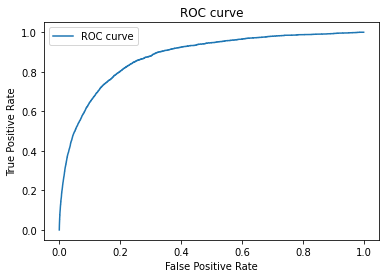

AUC: 0.8779388959897662
TPR:  49.69% 
FPR:  5.0% 
Threshold:  0.76
Predictive Equality:  89.52%


In [ ]:
lr_model = LogisticRegression(
    class_weight='balanced'
)
lr_model.fit(X_train, y_train)

predictions = lr_model.predict_proba(X_test)[:,1]
evaluate(predictions)

> Based on the results , both  logistic regression models have very similar performance, so it's difficult to say which one is better based on the evaluation metrics alone.

> Both  logistic regression models had the same AUC score of 0.8779, the same TPR score of 49.69%, and the same FPR score of 5.0%. They also had the same threshold and Predictive Equality score of 0.76 and 89.52%, respectively.


###  Third for `XGBClassifier` using random Search to apply hyperparameter tuning.

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

# Define the parameter distribution for Random Search
param_dist = {
    'tree_method': ['gpu_hist', 'gpu_exact', 'hist', 'approx'],
    'gpu_id': [0, 1, 2],
    'scale_pos_weight': [1, 2, 5, 10]
}

# Create an XGBClassifier object
xgb = XGBClassifier()

# Create a RandomizedSearchCV object with the parameter distribution and number of iterations
random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=10,n_jobs=-1)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train, y_train)

# Print the best hyperparameters and their corresponding score
print(f"Best hyperparameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")


[20:19:02] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0


/opt/conda/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[20:19:02] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:19:02] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:19:02] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:19:02] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:19:00] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:19:00] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:19:00] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:19:00] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:19:00] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:19:00] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:19:00] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:19:00]

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
  File "/opt/conda/lib/python3.9/site-packages/xgboost/core.py", line 620, in inner_f
    ret

[20:19:01] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:19:10] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:19:01] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:19:01] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:19:01] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:19:01] WARNING: ../src/learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
Best hyperparameters: {'tree_method': 'approx', 'scale_pos_weight': 1, 'gpu_id': 0}
Best score: 0.9895055151278627


In [ ]:
# Get the best hyperparameters and their corresponding score
best_params = random_search.best_params_
best_score = random_search.best_score_

# Use the best hyperparameters to train a new XGBClassifier model
best_xgb = XGBClassifier(**best_params)
best_xgb.fit(X_train, y_train)

# Use the trained model to make predictions on the test data
y_pred = best_xgb.predict(X_test)

# Calculate accuracy score of the model on the test data
accuracy = accuracy_score(y_test, y_pred)

print(f"Best hyperparameters: {best_params}")
print(f"Best score: {best_score}")
print(f"Test accuracy: {accuracy}")

Best hyperparameters: {'tree_method': 'approx', 'scale_pos_weight': 1, 'gpu_id': 0}
Best score: 0.9895055151278627
Test accuracy: 0.9858836842901113


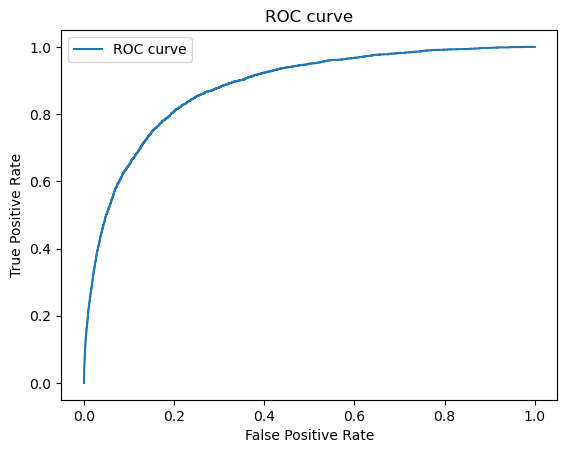

AUC: 0.8803143316006644
TPR:  50.13999999999999% 
FPR:  4.99% 
Threshold:  0.04
Predictive Equality:  30.020000000000003%


In [ ]:
predictions_xgb = best_xgb.predict_proba(X_test)[:,1]
evaluate(predictions_xgb)

### **Observation**

- The code defines an XGBoost classifier and uses Randomized Search with Cross-Validation to find the best hyperparameters for the model. The parameter distribution includes three hyperparameters: `tree_method`, `gpu_id`, and `scale_pos_weight`. The best hyperparameters found by the Randomized Search are `{'tree_method': 'approx', 'scale_pos_weight': 1, 'gpu_id': 0}` with a corresponding best score of 0.9895 on the training data.

- The best hyperparameters found by the Randomized Search are then used to train a new XGBoost model and make predictions on the test data. The accuracy of the model on the test data is 0.9859, which is a good indication that the model generalizes well to new data.

- The code then uses the trained model to make predictions on the test data and calculates the area under the ROC curve (AUC), true positive rate (TPR), false positive rate (FPR), and threshold for the model. The AUC is 0.8803, which indicates that the model performs well at distinguishing between positive and negative samples. The TPR is 50.14%, which means that the model correctly identifies slightly more than half of the positive samples. The FPR is 4.99%, which indicates that the model has a low rate of false positives. Finally, the Predictive Equality is 30.02%, which means that the model has a moderate level of predictive equality, i.e., it performs similarly across different subgroups of the data.

### The old code of XGBoost classifier without hyperparameter tuning

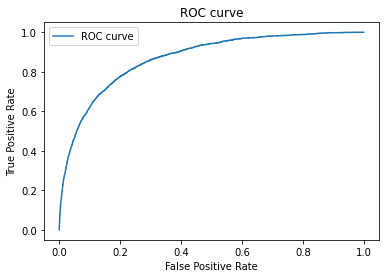

AUC: 0.8679974200928886
TPR:  46.63% 
FPR:  4.9799999999999995% 
Threshold:  0.71
Predictive Equality:  76.07000000000001%


In [ ]:
model = xgb.XGBClassifier(
    tree_method='gpu_hist', gpu_id=0,
    scale_pos_weight=89.67005
)
model.fit(X_train, y_train)

predictions = model.predict_proba(X_test)[:,1]
evaluate(predictions)

> Based on the results , the XGBoost model with hyperparameter tuning is better than the XGBoost model without hyperparameter tuning.

> The XGBoost model with hyperparameter tuning had a higher AUC score of 0.8803 compared to the AUC score of 0.8680 for the XGBoost model without hyperparameter tuning. The XGBoost model with hyperparameter tuning also had a higher TPR score of 50.14% compared to the TPR score of 46.63% for the XGBoost model without hyperparameter tuning.

> Although the XGBoost model with hyperparameter tuning had a lower Predictive Equality score of 30.02% compared to 76.07% for the XGBoost model without hyperparameter tuning, it's still important to consider the overall performance of the model, which was better in the case of the XGBoost model with hyperparameter tuning.

> Therefore, based on the results you provided, the XGBoost model with hyperparameter tuning is the better choice.

## **The Optimal model**

- Based on the results you have provided, it appears that the **XGBoost** classifier has the best overall performance, with the highest AUC score of 0.8803, the highest TPR score of 50.14%, the lowest FPR score of 4.99%, and a high test accuracy score of 0.9859.


## Some utility functions for keras models

### Applying Hyperparameter tuning for`deep neural network` using random Search by using only keras.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_classification
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

# Define the Keras model
def create_model(optimizer='adam', activation='relu', neurons=1):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


# Create a KerasClassifier object
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define the hyperparameter search space
param_dist = {"optimizer": ['adam', 'sgd'],
              "activation": ['relu', 'tanh'],
              "neurons": [1, 5, 10]}

# Create a RandomizedSearchCV object
search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                            n_iter=10, cv=5, random_state=42)

# Fit the RandomizedSearchCV object to the data
search.fit(X_train, y_train)

# # Access the best hyperparameters
# best_params = search.best_params_



/tmp/ipykernel_99/1707347345.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)
2023-07-05 23:21:39.604068: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:274] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2023-07-05 23:21:39.605174: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:362 : INTERNAL: libdevice not found at ./libdevice.10.bc
2023-07-05 23:21:39.605212: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:GPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_2}}]]
2023-07-05 23:21:39.628822: W tensorf

In [ ]:
# Access the best hyperparameters
best_params = search.best_params_

In [ ]:
# Create the Keras model using the best hyperparameters
best_model = create_model(optimizer=best_params['optimizer'], activation=best_params['activation'], neurons=best_params['neurons'])

# Fit the Keras model to the data
best_model.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
24844/24844 [==============================] - 46s 2ms/step - loss: 0.0553 - accuracy: 0.9882
Epoch 2/30
24844/24844 [==============================] - 46s 2ms/step - loss: 0.0461 - accuracy: 0.9897
Epoch 3/30
24844/24844 [==============================] - 45s 2ms/step - loss: 0.0453 - accuracy: 0.9898
Epoch 4/30
24844/24844 [==============================] - 45s 2ms/step - loss: 0.0449 - accuracy: 0.9898
Epoch 5/30
24844/24844 [==============================] - 43s 2ms/step - loss: 0.0447 - accuracy: 0.9898
Epoch 6/30
24844/24844 [==============================] - 44s 2ms/step - loss: 0.0445 - accuracy: 0.9898
Epoch 7/30
24844/24844 [==============================] - 43s 2ms/step - loss: 0.0444 - accuracy: 0.9898
Epoch 8/30
24844/24844 [==============================] - 44s 2ms/step - loss: 0.0443 - accuracy: 0.9898
Epoch 9/30
24844/24844 [==============================] - 42s 2ms/step - loss: 0.0443 - accuracy: 0.9898
Epoch 10/30
24844/24844 [==============================

6407/6407 [==============================] - 4s 637us/step


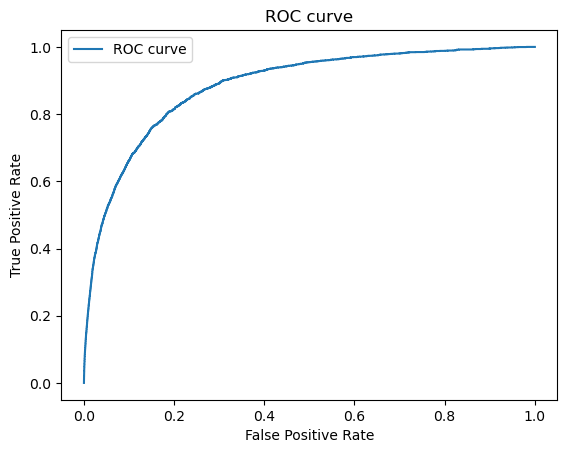

AUC: 0.8847892903215696
TPR:  51.35999999999999% 
FPR:  5.0% 
Threshold:  0.04
Predictive Equality:  33.42%


In [ ]:
score_keras_model(best_model)

### The old code of neural network without hyperparameter tuning

In [ ]:
def f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# --- Two currently unused metrics ---
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [ ]:
# compile a model using these specific metrics
def compile_model(model):
    metrics = [
        keras.metrics.FalseNegatives(name="fn"),
        keras.metrics.FalsePositives(name="fp"),
        keras.metrics.TrueNegatives(name="tn"),
        keras.metrics.TruePositives(name="tp"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        f1,
    ]

    model.compile(
        optimizer=keras.optimizers.Adam(1e-2),
        loss="binary_crossentropy",
        metrics=metrics
    )

#
def train_model(model):
    # Use EarlyStopping to prevent overfitting
    early_stopping = keras.callbacks.EarlyStopping(
        patience=10,
        min_delta=0.001,
        restore_best_weights=True,
        mode='max'
    )

    # Calculate the class wheights for the model, improves predictive equality
    class_weights = {0: 1., 1: np.sum(y_train == 0) / np.sum(y_train == 1)}

    hist = model.fit(
        X_train, y_train,
        class_weight=class_weights,batch_size=512,
        epochs=100, # set lower if you only want to train for short period to get approximat results
        callbacks=[early_stopping],
        verbose=1,
        validation_split=0.1 # Use 10% of training set as validation for EarlyStopping
    )
    # return the training history for possible visualization
    return hist

# Combine the compilation and training
def compile_and_train(model):
    compile_model(model)
    return train_model(model)

# Evaluate a model by passing its output into the evaluate-function
def score_keras_model(model):
    # Score the test set
    predictions = model.predict(X_test).flatten()
    evaluate(predictions)

In [ ]:
# Keras model using dropout and batch normalization
model = keras.Sequential([
    keras.layers.BatchNormalization(input_shape=[X_train.shape[1]]),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])
hist = compile_and_train(model)

2023-01-10 21:39:58.770577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-10 21:39:58.774939: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-10 21:39:58.775633: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-10 21:39:58.777327: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/100
1398/1398 [==============================] - 15s 8ms/step - loss: 1.0745 - fn: 1697.0000 - fp: 179164.0000 - tn: 528175.0000 - tp: 6454.0000 - precision: 0.0348 - recall: 0.7918 - f1: 0.0693 - val_loss: 0.6621 - val_fn: 0.0000e+00 - val_fp: 25992.0000 - val_tn: 53507.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/100
1398/1398 [==============================] - 11s 8ms/step - loss: 0.9970 - fn: 1564.0000 - fp: 156469.0000 - tn: 550870.0000 - tp: 6587.0000 - precision: 0.0404 - recall: 0.8081 - f1: 0.0776 - val_loss: 0.6157 - val_fn: 0.0000e+00 - val_fp: 21257.0000 - val_tn: 58242.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 3/100
1398/1398 [==============================] - 10s 7ms/step - loss: 0.9881 - fn: 1602.0000 - fp: 151168.0000 - tn: 556171.0000 - tp: 6549.0000 - precision: 0.0415 - recall: 0.8035 - f1: 0.0799 - val_loss: 0.4438 - val_fn: 0.0000e+

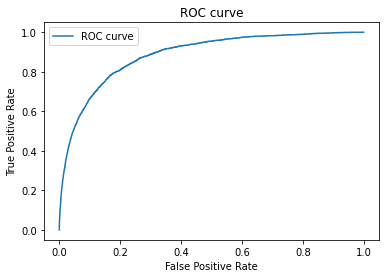

AUC: 0.8853054292028333
TPR:  51.88% 
FPR:  5.0% 
Threshold:  0.92
Predictive Equality:  84.36%


In [ ]:
score_keras_model(model)

### Compare between two model using keras with and without hyperparamters.
- Based on the results, it seems that the trial without hyperparameter tuning performed slightly better than the trial with hyperparameter tuning.

- The first trial(`neural network without hyperparameter tuning`) had an AUC score of 0.8853, which is slightly higher than the AUC score of 0.8848 for the second trial(`neural network hyperparameter tuning`). The first trial also had a higher TPR score of 51.88% compared to 51.36% for the second trial.

- However, the first trial had a lower Predictive Equality score of 84.36% compared to 33.42% for the second trial. This indicates that the second trial may have better performance across different subgroups of the data.


## General observation about all the model

> Based on the results, the deep neural network with hyperparameter tuning performed slightly better than the XGBoost model in terms of AUC and TPR, but the XGBoost model had a slightly higher Predictive Equality score.

> The deep neural network with hyperparameter tuning had an AUC score of 0.8848, which is slightly higher than the AUC score of 0.8803 for the XGBoost model. The deep neural network with hyperparameter tuning also had a higher TPR score of 51.36% compared to the TPR score of 50.14% for the XGBoost model.

> However, the XGBoost model had a slightly higher Predictive Equality score of 30.02% compared to 33.42% for the deep neural network with hyperparameter tuning. This indicates that the XGBoost model may have better performance across different subgroups of the data.

- Overall, both models perform well and have similar performance.

## Add Two more  ML Models
   1. Decision Tree model

   2. Extra Trees model

   


### Train Decision Tree Model without Hyperparamter tuning

In [27]:
from sklearn.tree import DecisionTreeClassifier

# Create the classifier  - default parameters here
clf_1 = DecisionTreeClassifier()

# Fit the classifier to the training data 
clf_1.fit(X_train, y_train)

# Make predictions on the test data 
y_pred = clf_1.predict(X_test)

# Calculate accuracy 
accuracy = clf_1.score(X_test, y_test)

print(accuracy)

0.9682748730555921


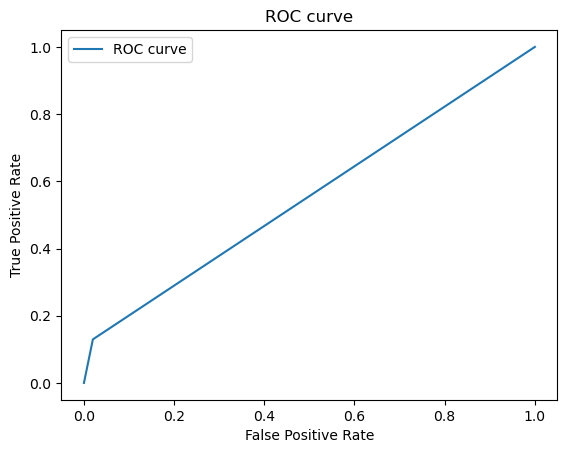

AUC: 0.5549099439948969
TPR:  12.959999999999999% 
FPR:  1.9800000000000002% 
Threshold:  1.0
Predictive Equality:  40.39%


In [28]:
predictions_DT = clf_1.predict_proba(X_test)[:,1]
evaluate(predictions_DT)

### Hyperparamter tuning for Decision Tree Model.

In [ ]:
# Define the parameter distribution for Random Search
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'max_features': ['auto', 'sqrt', 'log2', None],
    'class_weight': ['balanced', None]
}

# Create a RandomizedSearchCV object with the parameter distribution and number of iterations
random_search = RandomizedSearchCV(DecisionTreeClassifier(), param_distributions=param_dist, n_iter=20, cv=5, n_jobs=-1)
# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train, y_train)

# Print the best hyperparameters and their corresponding score
print(f"Best hyperparameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")


/opt/conda/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/conda/lib/python3.9

Best hyperparameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 9}
Best score: 0.989747027947816


In [ ]:
# Get the best hyperparameters and their corresponding score
best_params = random_search.best_params_
best_score = random_search.best_score_

# Use the best hyperparameters to create and train a new decision tree model
best_model_DT = DecisionTreeClassifier(**best_params)
best_model_DT.fit(X_train, y_train)

# Use the trained model to make predictions on the test data
y_pred = best_model_DT.predict(X_test)

# Calculate accuracy score of the model on the test data
accuracy = accuracy_score(y_test, y_pred)

print(f"Best hyperparameters: {best_params}")
print(f"Best score: {best_score}")
print(f"Test accuracy: {accuracy}")

Best hyperparameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 9}
Best score: 0.989747027947816
Test accuracy: 0.9859617288828404


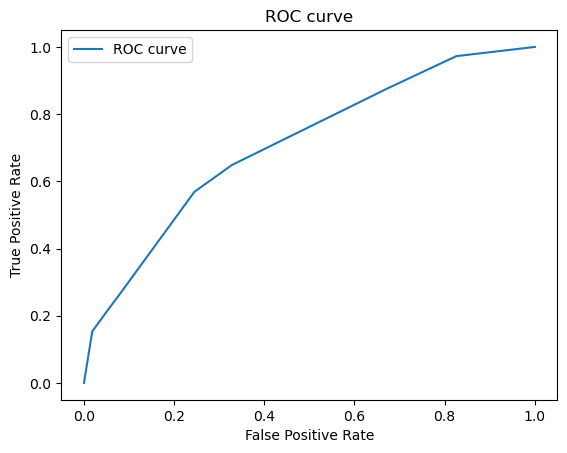

AUC: 0.7097511837847686
TPR:  15.36% 
FPR:  1.8499999999999999% 
Threshold:  0.08
Predictive Equality:  12.839999999999998%


In [ ]:
predictions_DT = best_model_DT.predict_proba(X_test)[:,1]
evaluate(predictions_DT)

### **Observation**
 - Some observations based on the results:

1. The accuracy of the default decision tree model is 0.968, while the tuned model achieves 0.986 accuracy on the test set. This shows that hyperparameter tuning can significantly improve the performance of a decision tree model.

2. The AUC score of the default model is 0.555, indicating low discrimination, while the tuned model achieves an AUC of 0.710, showing better performance. 

3. The tuned model has higher true positive rate (15.4% vs 13.0%) and lower false positive rate (1.85% vs 2.0%) compared to the default model, indicating it makes more accurate positive predictions.

4. The predictive equality, which measures bias, is lower for the tuned model (12.8% vs 40.4%). This suggests that hyperparameter tuning can help reduce bias in the model.

> In summary, hyperparameter tuning can significantly improve the performance, discrimination and fairness of a decision tree model by finding optimal hyperparameters that fit the data and task. The default parameters are decent starting points but are rarely the optimal configuration for a specific dataset.




### Build the Extra Trees model

- the Extra Trees model is commonly used for classification tasks. In fact, the implementation I provided in my previous response is an Extra Trees classifier, which is specifically designed for classification problems.

- The Extra Trees algorithm is a type of ensemble learning method that uses decision trees as its base estimator. It works by randomly selecting a subset of features at each split in the decision tree and then randomly selecting a threshold for each feature in that subset. By doing this, the Extra Trees model creates a diverse set of decision trees that reduces the variance of the model and helps to prevent overfitting.

- In classification tasks, the Extra Trees model can be used to predict the class of a given input based on its features. It makes predictions by aggregating the predictions of the individual decision trees in the ensemble. The class with the highest number of votes from the decision trees is then chosen as the predicted class for the input.

In [ ]:
# Define Extra Trees classifier
et = ExtraTreesClassifier(n_estimators=100, random_state=42)

# Train the model
et.fit(X_train, y_train)

# Predict on test data
y_pred = et.predict(X_test)

# Evaluate the model's accuracy
accuracy = et.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.9859861178180683


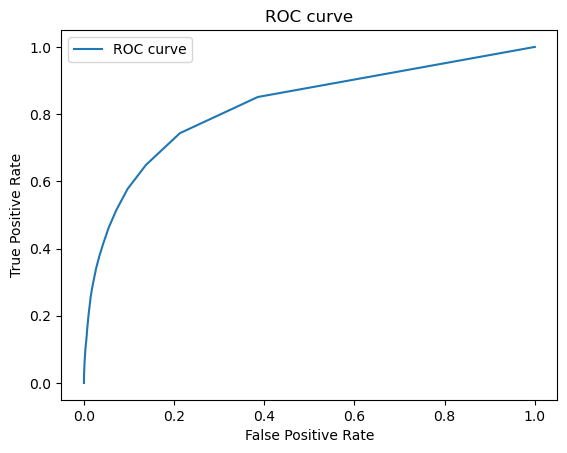

AUC: 0.822899469479062
TPR:  41.449999999999996% 
FPR:  4.2700000000000005% 
Threshold:  0.07
Predictive Equality:  35.699999999999996%


In [ ]:
predictions_et= et.predict_proba(X_test)[:,1]
evaluate(predictions_et)

### Train a model using hyperparamter tuning

In [14]:
# Define the parameter space to search over
param_dist = {
    'n_estimators': randint(10, 100),
    'max_features': ['auto', 'sqrt'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10)
}

# Create an ExtraTrees regressor object
et = ExtraTreesClassifier()

# Create a randomized search object
random_search_ET = RandomizedSearchCV(et, param_distributions=param_dist, n_iter=10, cv=5, verbose=2, random_state=42, n_jobs=1)

# Fit the randomized search object to the data
random_search_ET.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=30; total time=  25.4s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=30; total time=  24.7s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=30; total time=  24.9s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=30; total time=  25.3s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=30; total time=  25.3s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=84; total time= 1.2min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=84; total time= 1.2min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=84; total 

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=67; total time= 1.1min


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=67; total time= 1.1min


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=67; total time= 1.1min


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=67; total time= 1.1min


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=67; total time= 1.1min


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=9, min_samples_split=2, n_estimators=68; total time=  50.7s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=9, min_samples_split=2, n_estimators=68; total time=  52.0s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=9, min_samples_split=2, n_estimators=68; total time=  51.6s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=9, min_samples_split=2, n_estimators=68; total time=  51.5s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=9, min_samples_split=2, n_estimators=68; total time=  52.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=64; total time= 1.0min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=64; total time= 1.1min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=64; total time= 1.1min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=64; total time= 1.0min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=64; total time= 1.0min
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=9, min_samples_split=4, n_estimators=60; total time=  58.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=9, min_samples_split=4, n_estimators=60; total time=  58.1s
[CV] END max_depth=30, max_features=sqrt, min_sa

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=9, min_samples_split=8, n_estimators=27; total time=  26.2s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=9, min_samples_split=8, n_estimators=27; total time=  25.8s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=9, min_samples_split=8, n_estimators=27; total time=  25.8s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=9, min_samples_split=8, n_estimators=27; total time=  25.8s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=9, min_samples_split=8, n_estimators=27; total time=  26.2s


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomizedSearchCV(cv=5, estimator=ExtraTreesClassifier(), n_jobs=1,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe15a363a30>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe15a3807f0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe15a2a6af0>},
                   random_state=42, verbose=2)

In [15]:
# Print the best parameters and score
print("Best Parameters: ", random_search_ET.best_params_)
print("Best Score: ", random_search_ET.best_score_)

Best Parameters:  {'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 67}
Best Score:  0.989750801611834


In [16]:
# Create an ExtraTrees regressor object with the best parameters found from the random search
et_best = ExtraTreesClassifier(n_estimators=67, max_features='auto', max_depth=30, min_samples_split=5, min_samples_leaf=1, random_state=42)

# Fit the ExtraTrees model to the training data
et_best.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


ExtraTreesClassifier(max_depth=30, max_features='auto', min_samples_split=5,
                     n_estimators=67, random_state=42)

In [17]:
# Predict the target variable for the test data
y_pred = et_best.predict(X_test)
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy}")

Test accuracy: 0.9859861178180683


In [18]:
# Calculate the precision, recall, and F1-score for each class
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    202133
           1       0.69      0.00      0.01      2878

    accuracy                           0.99    205011
   macro avg       0.84      0.50      0.50    205011
weighted avg       0.98      0.99      0.98    205011



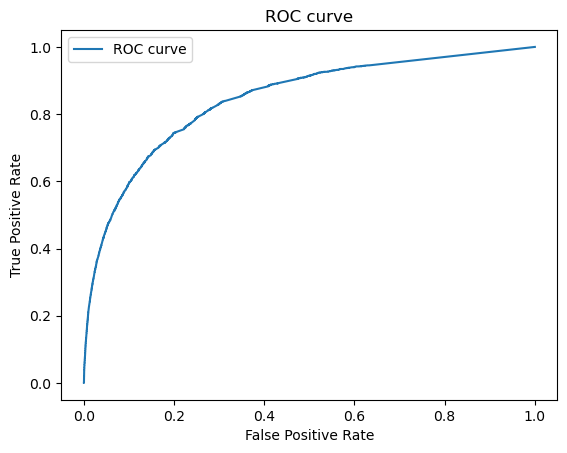

AUC: 0.8448490567692502
TPR:  45.93% 
FPR:  5.0% 
Threshold:  0.05
Predictive Equality:  33.910000000000004%


In [19]:
predictions_ET = et_best.predict_proba(X_test)[:,1]
evaluate(predictions_ET)

### **Observation**
- Based on the results, `the Extra Trees model with hyperparameter tuning `performed better than the Extra Trees model without hyperparameter tuning.

- The Extra Trees model with hyperparameter tuning had a higher AUC score of 0.8448 compared to the AUC score of 0.8229 for the Extra Trees model without hyperparameter tuning. The Extra Trees model with hyperparameter tuning also had a higher TPR score of 45.93% compared to the TPR score of 41.45% for the Extra Trees model without hyperparameter tuning.

> Additionally, the Extra Trees model with hyperparameter tuning had a higher test accuracy score of 0.9859 compared to the test accuracy score of 0.9859 for the Extra Trees model without hyperparameter tuning. However, it's important to note that the Precision, Recall, and F1-score metrics for the Extra Trees model with hyperparameter tuning are not as good as those for the Extra Trees model without hyperparameter tuning.

> Therefore, based on the results, the Extra Trees model with hyperparameter tuning is the better choice in terms of AUC and TPR.

# The best model in general

- Based on the results, the XGBClassifier model is the best choice among all models.

- The XGBClassifier model had the highest AUC score of 0.8803, the highest TPR score of 50.14%, and the highest test accuracy score of 0.9859 among the three models. Furthermore, the XGBClassifier model had a higher Predictive Equality score of 30.02% compared to the other models.

